In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
try:
    import mxnet as mx
except:
    sys.stderr.write("Cannot import mxnet.\n")
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk
No vtk

Setting environment for Precision WorkStation


Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

In [3]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=1, batch_size=batch_size)

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [4]:
win_id = 5

In [5]:
def extract_one_metric(metrics_all_ntrain, which, thresh=None):
    if thresh is None:
        return {ntrain: {test_cond: [res[which] for res in res_all_trials]
                   for test_cond, res_all_trials in x.iteritems()}
         for ntrain, x in metrics_all_ntrain.iteritems()}
    else:
        return {ntrain: {test_cond: [res[which][thresh] for res in res_all_trials]
                   for test_cond, res_all_trials in x.iteritems()}
         for ntrain, x in metrics_all_ntrain.iteritems()}

In [6]:
def plot_result_wrt_ntrain(test_metrics_all_ntrain, ylabel='', title=''):

    for test_condition in test_metrics_all_ntrain.values()[1].keys():
        ntrains, accs, errs = zip(*sorted([(ntrain, np.mean(x[test_condition]), np.std(x[test_condition]))
              for ntrain, x in test_metrics_all_ntrain.iteritems() if len(x) > 0]))
        plt.errorbar(ntrains, accs, yerr=errs, label=test_condition[1]);
    plt.xlabel('# traing patches');
    plt.ylabel(ylabel);
    plt.title(title);
    plt.legend(loc='upper right');
    plt.ylim([0.5, 1.]);
    plt.xlim([0,16000]);
    plt.show()

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/home/yuncong/CSHL_labelings_v3/MD589" --exclude "*" --include "*win5*grid_indices_lookup*"
latest timestamp:  10042017100807
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD642" "/home/yuncong/CSHL_labelings_v3/MD642" --exclude "*" --include "*win5*warp*grid_indices_lookup*"
latest timestamp:  01042018210922


Computing class label to grid indices lookup-table for section 92...
Computing class label to grid indices lookup-table for section 94...
Computing class label to grid indices lookup-table for section 95...
Computing class label to grid indices lookup-table for section 96...
Computing class label to grid indices lookup-table for section 97...
Computing class label to grid indices lookup-table for section 98...
Computing class label to grid indices lookup-table for section 99...
Computing class label to grid indices lookup-table for section 100...
Computing class label to grid indices lookup-table for section 101...
Computing class label to grid indices lookup-table for section 102...
Computing class label to grid indices lookup-table for section 103...
Computing class label to grid indices lookup-table for section 104...
Computing class label to grid indices lookup-table for section 105...
Computing class label to grid indices lookup-table for section 106...
Computing class label to gr

MD589, sec 175: 524 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 176...
MD589, sec 176: 182 patches from label 7N.
MD589, sec 176: 493 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 177...
MD589, sec 177: 137 patches from label 7N.
MD589, sec 177: 508 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 178...
MD589, sec 178: 149 patches from label 7N.
MD589, sec 178: 493 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 179...
MD589, sec 179: 166 patches from label 7N.
MD589, sec 179: 502 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 180...
MD589, sec 180: 187 patches from label 7N.
MD589, sec 180: 529 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table 

Computing class label to grid indices lookup-table for section 266...
Computing class label to grid indices lookup-table for section 267...
Computing class label to grid indices lookup-table for section 268...
Computing class label to grid indices lookup-table for section 269...
Computing class label to grid indices lookup-table for section 270...
Computing class label to grid indices lookup-table for section 271...
Computing class label to grid indices lookup-table for section 272...
Computing class label to grid indices lookup-table for section 273...
Computing class label to grid indices lookup-table for section 274...
MD589, sec 274: 4 patches from label 7N.
MD589, sec 274: 188 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 275...
MD589, sec 275: 25 patches from label 7N.
MD589, sec 275: 307 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 276...
MD589, sec 276: 44 

MD642, sec 139: 62 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 140...
MD642, sec 140: 319 patches from label 7N_surround_200_Sp5O.
MD642, sec 140: 98 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 141...
MD642, sec 141: 371 patches from label 7N_surround_200_Sp5O.
MD642, sec 141: 93 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 142...
MD642, sec 142: 479 patches from label 7N_surround_200_Sp5O.
MD642, sec 142: 95 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 143...
MD642, sec 143: 515 patches from label 7N_surround_200_Sp5O.
MD642, sec 143: 91 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 144...
MD642, sec 144: 6 patches from label 7N.
MD642, sec 144: 546 patches from label 7N_surround

Computing class label to grid indices lookup-table for section 183...
MD642, sec 183: 0 patches from label 7N.
MD642, sec 183: 461 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 184...
MD642, sec 184: 391 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 185...
MD642, sec 185: 350 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 186...
MD642, sec 186: 251 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 187...
Computing class label to grid indices lookup-table for section 188...
Computing class label to grid indices lookup-table for section 189...
Computing class label to grid indices lookup-table for section 190...
Computing class label to grid indices lookup-table for section 191...
Computing class label to grid indices lookup-table for section 192...
Com

MD642, sec 276: 89 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 277...
MD642, sec 277: 203 patches from label 7N.
MD642, sec 277: 556 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 278...
MD642, sec 278: 201 patches from label 7N.
MD642, sec 278: 572 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 279...
MD642, sec 279: 194 patches from label 7N.
MD642, sec 279: 591 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 280...
MD642, sec 280: 186 patches from label 7N.
MD642, sec 280: 609 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 281...
MD642, sec 281: 190 patches from label 7N.
MD642, sec 281: 609 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table f

Section 152 provides 32 positive patches.
Section 153 provides 49 positive patches.
Section 154 provides 75 positive patches.
Section 155 provides 108 positive patches.
Section 156 provides 125 positive patches.
Section 157 provides 146 positive patches.
Section 158 provides 169 positive patches.
Section 159 provides 190 positive patches.
Section 160 provides 224 positive patches.
Section 161 provides 230 positive patches.
Section 162 provides 238 positive patches.
Section 163 provides 251 positive patches.
Section 164 provides 261 positive patches.
Section 165 provides 280 positive patches.
Section 166 provides 268 positive patches.
Section 167 provides 265 positive patches.
Section 168 provides 257 positive patches.
Section 169 provides 252 positive patches.
Section 170 provides 244 positive patches.
Section 171 provides 235 positive patches.
Section 172 provides 233 positive patches.
Section 173 provides 231 positive patches.
Section 174 provides 224 positive patches.
Section 175 pr

No images are provided. Load instead.
Not using image_cache.
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
Load image: 20.66 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 22.54 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 20.41 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 15.46 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 15.02 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 15.08 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 15.01 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 14.69 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 14.84 seconds.
No images are provided. Loa

(5562, 1, 224, 224)


Feature computation: 8.33 seconds
Compute variants: 0.00 seconds


(5562, 1, 224, 224)


Feature computation: 8.46 seconds
Compute variants: 0.00 seconds


(5562, 1, 224, 224)


Feature computation: 8.29 seconds
Compute variants: 0.00 seconds


(5562, 1, 224, 224)


Feature computation: 8.37 seconds
Compute variants: 0.00 seconds


(5562, 1, 224, 224)


Feature computation: 8.44 seconds
Compute variants: 0.00 seconds


(5562, 1, 224, 224)


Feature computation: 8.44 seconds
Compute variants: 0.01 seconds


(5562, 1, 224, 224)


Feature computation: 8.99 seconds
Compute variants: 0.00 seconds


(5562, 1, 224, 224)


Feature computation: 9.13 seconds
No images are provided. Load instead.
Not using image_cache.
Load image: 11.65 seconds.
No images are provided. Load instead.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD642/MD642_prep2_lossless/MD642-N34-2017.01.19-11.11.50_MD642_1_0100_prep2_lossless.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD642/MD642_prep2_lossless"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless/MD642-N34-2017.01.19-11.11.50_MD642_1_0100_prep2_lossless.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD642/MD642_prep2_lossless/MD642-N34-2017.01.19-11.11.50_MD642_1_0100_prep2_lossless.tif"


Not using image_cache.
Load image: 23.19 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 13.03 seconds.
No images are provided. Load instead.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD642/MD642_prep2_lossless/MD642-N29-2017.01.19-10.53.19_MD642_1_0085_prep2_lossless.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD642/MD642_prep2_lossless"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless/MD642-N29-2017.01.19-10.53.19_MD642_1_0085_prep2_lossless.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD642/MD642_prep2_lossless/MD642-N29-2017.01.19-10.53.19_MD642_1_0085_prep2_lossless.tif"


Not using image_cache.
Load image: 20.80 seconds.
No images are provided. Load instead.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD642/MD642_prep2_lossless/MD642-N32-2017.01.19-11.04.20_MD642_1_0094_prep2_lossless.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD642/MD642_prep2_lossless"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless/MD642-N32-2017.01.19-11.04.20_MD642_1_0094_prep2_lossless.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD642/MD642_prep2_lossless/MD642-N32-2017.01.19-11.04.20_MD642_1_0094_prep2_lossless.tif"


Not using image_cache.
Load image: 21.68 seconds.
No images are provided. Load instead.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD642/MD642_prep2_lossless/MD642-N34-2017.01.19-11.11.50_MD642_2_0101_prep2_lossless.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD642/MD642_prep2_lossless"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_prep2_lossless/MD642-N34-2017.01.19-11.11.50_MD642_2_0101_prep2_lossless.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD642/MD642_prep2_lossless/MD642-N34-2017.01.19-11.11.50_MD642_2_0101_prep2_lossless.tif"


Not using image_cache.
Load image: 21.91 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 11.79 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 15.68 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 12.76 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 11.95 seconds.
Compute variants: 0.01 seconds


(7652, 1, 224, 224)


Feature computation: 11.35 seconds
Fitting classifier: 0.01 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.02 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.01 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.02 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.01 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.01 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.02 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.01 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.01 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.01 seconds
Fitting classifier: 0.00 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.14 seconds
Fitting classifier: 0.42 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.27 seconds
Fitting classifier: 0.42 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.78 seconds
Fitting classifier: 0.48 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.69 seconds
Fitting classifier: 0.46 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.80 seconds
Fitting classifier: 0.45 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 7.24 seconds
Fitting classifier: 0.44 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.52 seconds
Fitting classifier: 0.42 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.20 seconds
Fitting classifier: 0.43 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.66 seconds
Fitting classifier: 0.40 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.92 seconds
Fitting classifier: 0.44 seconds


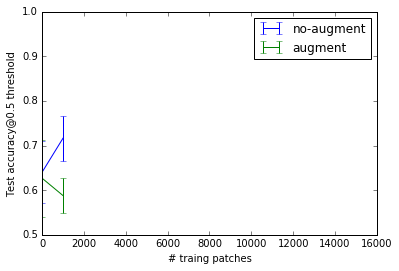

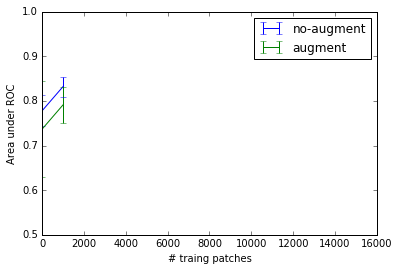

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


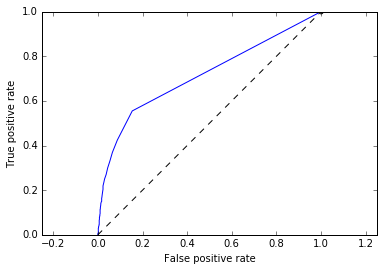

In [7]:
for stack1 in ['MD589']:
    
    stacks = [stack1, 'MD642']
    
    #############################
    
    sample_locations_allStacks = {stack: grid_parameters_to_sample_locations(win_id_to_gridspec(win_id=5, stack=stack)) 
                              for stack in stacks}
    
    #############################
    
    grid_indices_lookup_allStacks = {}

    for stack in [stack1]:
        try:
#             grid_indices_lookup_allStacks[stack] = \
#             DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
#                                                                by_human=False, timestamp='latest',
#                                                                detector_id_f=1)
            
            grid_indices_lookup_allStacks[stack] = \
            DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
                                                               by_human=True, timestamp='latest')
        except Exception as e:
            print e
            sys.stderr.write("Fail to load annotation grid lookup for %s.\n" % stack)


    stack = 'MD642'
    try:
#         grid_indices_lookup_allStacks[stack] = \
#         DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
#                                                            by_human=True, timestamp='latest')
        grid_indices_lookup_allStacks[stack] = \
        DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
                                                           by_human=False, timestamp='latest',
                                                           detector_id_f=13)
    except:
        sys.stderr.write("Fail to load annotation grid lookup for %s.\n" % stack)
        
    #############################
    
    from itertools import chain
    all_labels = sorted(list(set(chain.from_iterable(set(grid_indices_lookup_allStacks[st].columns.tolist()) for st in stacks))))
    
    address_multidx = pd.MultiIndex.from_tuples([(stack, sec, grid_idx) 
           for stack in sorted(stacks)
           for sec in np.arange(metadata_cache['section_limits'][stack][0], 
                                metadata_cache['section_limits'][stack][-1]+1)
           for grid_idx in range(len(sample_locations_allStacks[stack]))], 
          names=['stack', 'section', 'grid_idx'])
    
    address_label_df_allStacks = DataFrame(columns=all_labels,
    index=address_multidx, data=False)
    
    # surround_margins = [200, 500]
    surround_margins = [200]
    
    # Option 1: Use the cached file that stores the mapping from grid-indices to labels for speed up.

    for stack in stacks:
    # for stack in ['MD661']:
    # for stack in ['ChatCryoJane201710']:

        grid_index_class_lookup = grid_indices_lookup_allStacks[stack]

        for sec in grid_index_class_lookup.index:
            sys.stderr.write('Computing class label to grid indices lookup-table for section %d...\n' % sec)
            if is_invalid(sec=sec, stack=stack):
                continue

            for label, grid_indices in grid_index_class_lookup.loc[sec].dropna().iteritems():
                if label == 'bg' or label == 'noclass' or 'negative' in label: # Ignore bg, noclass, x_negative
                    continue

                name, side, margin, surr_name = parse_label(label)

                if name == '7N' and (margin is None or (margin is not None and int(margin) in surround_margins)):

                    sys.stderr.write("%s, sec %d: %d patches from label %s.\n" % (stack, sec, len(grid_indices), label))
        #             t = time.time()
                    for grid_idx in grid_indices:
                        address_label_df_allStacks.loc[(stack, sec, grid_idx), label] = True
        #             sys.stderr.write("%.2f s\n" % (time.time()-t))

    del grid_indices_lookup_allStacks
    
    ###################################
    
    # structure = 'Amb'
    structure = '7N'
    # structure = 'SNR'
    positive_labels = [structure]
    negative_labels = get_negative_labels(structure, 'neg_has_all_surround', margin_um=200, 
                                          labels_found=address_label_df_allStacks.columns)
    # negative_labels = get_negative_labels(structure, 'neg_has_all_surround', margin_um=500, 
    #                                       labels_found=address_label_df_allStacks.columns)
    
    ####################################
    
    train_stacks = [stack1]
    test_stacks = ['MD642']
    
    train_stack_section_number = {stack1: 10}
    test_stack_section_number = {'MD642': 10}

    train_stack_stain = {stack1: 'A'}
    test_stack_stain = {'MD642': 'N'}
    
    positive_addresses_traindata_all_stacks = {}
    negative_addresses_traindata_all_stacks = {}

    for train_stack in train_stacks:

        q = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)]
        all_sections = np.unique(q.loc[train_stack].index.get_level_values('section'))
        train_sections = [] # sections that contain patches of relevant classes.
        for sec in all_sections:
            try:
                if len(q.loc[train_stack, sec].index.values.tolist()) > 0:
                    train_sections.append(sec)
                    print 'Section', sec, 'provides', len(q.loc[train_stack, sec].index.values.tolist()), 'positive patches.'
            except:
                pass

        ###################################################################################

        n_train_sections = train_stack_section_number[train_stack]
        # n_train_sections = 10
        # n_train_sections = len(train_sections)

        neurotrace_sections = []
        nissl_sections = []
        for sec in train_sections:
            if metadata_cache['sections_to_filenames'][train_stack][sec].split('-')[1][0] == 'F':
                neurotrace_sections.append(sec)
            else:
                nissl_sections.append(sec)
        
        if train_stack_stain[train_stack] == 'F':
            random_train_sections = np.random.choice(neurotrace_sections, min(len(neurotrace_sections), n_train_sections), replace=False)
        elif train_stack_stain[train_stack] == 'N':
            random_train_sections = np.random.choice(nissl_sections, min(len(nissl_sections), n_train_sections), replace=False)
        else:
            random_train_sections = np.random.choice(train_sections, min(len(train_sections), n_train_sections), replace=False)

        positive_addresses_traindata_all_stacks[train_stack] = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[[train_stack], random_train_sections, :].index.values.tolist() 
        negative_addresses_traindata_all_stacks[train_stack] = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[[train_stack], random_train_sections, :].index.values.tolist() 

    positive_addresses_traindata = sum(positive_addresses_traindata_all_stacks.values(), [])
    negative_addresses_traindata = sum(negative_addresses_traindata_all_stacks.values(), [])

    print '# positive train =', len(positive_addresses_traindata)
    print '# negative train =', len(negative_addresses_traindata)

    del positive_addresses_traindata_all_stacks, negative_addresses_traindata_all_stacks
    
    positive_addresses_testdata_all_stacks = {}
    negative_addresses_testdata_all_stacks = {}

    for test_stack in test_stacks:

        q = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)]
        all_sections = np.unique(q.loc[test_stack].index.get_level_values('section'))
        test_sections = [] # sections that contain patches of relevant classes.
        for sec in all_sections:
            try:
                if len(q.loc[test_stack, sec].index.values.tolist()) > 0:
                    test_sections.append(sec)
                    print 'Section', sec, 'provides', len(q.loc[test_stack, sec].index.values.tolist()), 'positive patches.'
            except:
                pass

        #####################################################################################

        n_test_sections = test_stack_section_number[test_stack]
    #     n_test_sections = 10
        # n_test_sections = len(test_sections)

        neurotrace_sections = []
        nissl_sections = []
        for sec in test_sections:
            if metadata_cache['sections_to_filenames'][test_stack][sec].split('-')[1][0] == 'F':
                neurotrace_sections.append(sec)
            else:
                nissl_sections.append(sec)
        
        if test_stack_stain[test_stack] == 'F':
            random_test_sections = np.random.choice(neurotrace_sections, min(len(neurotrace_sections), n_test_sections), replace=False)
        elif test_stack_stain[test_stack] == 'N':
            random_test_sections = np.random.choice(nissl_sections, min(len(nissl_sections), n_test_sections), replace=False)
        else:
            random_test_sections = np.random.choice(test_sections, min(len(test_sections), n_test_sections), replace=False)

        positive_addresses_testdata_all_stacks[test_stack] = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[[test_stack], random_test_sections, :].index.values.tolist()
        negative_addresses_testdata_all_stacks[test_stack] = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[[test_stack], random_test_sections, :].index.values.tolist()

    positive_addresses_testdata = sum(positive_addresses_testdata_all_stacks.values(), [])
    negative_addresses_testdata = sum(negative_addresses_testdata_all_stacks.values(), [])

    print '# positive test =', len(positive_addresses_testdata)
    print '# negative test =', len(negative_addresses_testdata)

    del positive_addresses_testdata_all_stacks, negative_addresses_testdata_all_stacks
    
    # schemes = ['normalize_mu_region_sigma_wholeImage_(-1,9)']
    # schemes = ['normalize_mu_region_sigma_wholeImage_(-1,9)', 'median_curve']
    # schemes = ['normalize_mu_region_sigma_wholeImage_(-1,5)']
    # schemes = ['stretch_min_max']
    # schemes = [None, 'stretch_min_max']
    # schemes = ['none']
    # schemes = [None, 'median_curve']
    # transforms = ['transform%d' % i for i in range(8)]
    # scheme_transform_multiindex = pd.MultiIndex.from_product([schemes, transforms])

    # features_dict = {(scheme, tfv): {} for scheme in schemes for tfv in transforms}
    features_dict = defaultdict(dict)
    
    # train_scheme = 'stretch_min_max'
    # train_scheme = 'normalize_mu_sigma_global_(-1,5)'
#     train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
    # train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
    train_scheme = 'none'
    addresses_to_compute = positive_addresses_traindata + negative_addresses_traindata

    patches_with_desired_label = \
    extract_patches_given_locations_multiple_sections(addresses=addresses_to_compute,
    #                                                     images={('MD661', 199): img},
                                                  win_id=win_id, 
                                                normalization_scheme=train_scheme,
                                                 location_or_grid_index='grid_index')

    #     display_images_in_grids(patches_with_desired_label, nc=10, cmap=plt.cm.gray)

    # for variant in [0]:
    for variant in range(8):

        t = time.time()
    #             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
        patches_rotated = rotate_all_patches_variant(patches_with_desired_label, variant=variant)
        sys.stderr.write('Compute variants: %.2f seconds\n' % (time.time() - t))

        t = time.time()
        features = convert_image_patches_to_features_v2(patches_rotated, model=model, 
                                                     mean_img=mean_img, 
    #                                                      mean_img=np.zeros((224,224), dtype=np.uint8), 
                                                     batch_size=batch_size)
        sys.stderr.write('Feature computation: %.2f seconds\n' % (time.time() - t))

        for i, f in enumerate(features):
    #             features_df.loc[addresses_with_desired_label[i]][(scheme, 'transform%d'%variant)] = f
            features_dict[(train_scheme, 'transform%d'%variant)][addresses_to_compute[i]] = f
        
    
    # test_scheme = 'stretch_min_max'
    # test_scheme = 'normalize_mu_sigma_global_(-1,5)'
#     test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
#     test_scheme = 'median_curve'
    # test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
    test_scheme = 'none'
    addresses_to_compute = positive_addresses_testdata + negative_addresses_testdata

    patches_with_desired_label = \
    extract_patches_given_locations_multiple_sections(addresses=addresses_to_compute,
    #                                                     images={('MD661', 199): img},
                                                  win_id=win_id, 
                                                normalization_scheme=test_scheme,
                                                 location_or_grid_index='grid_index')

    #     display_images_in_grids(patches_with_desired_label, nc=10, cmap=plt.cm.gray)

    for variant in [0]:
    # for variant in range(8):

        t = time.time()
    #             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
        patches_rotated = rotate_all_patches_variant(patches_with_desired_label, variant=variant)
        sys.stderr.write('Compute variants: %.2f seconds\n' % (time.time() - t))

        t = time.time()
        features = convert_image_patches_to_features_v2(patches_rotated, model=model, 
                                                     mean_img=mean_img, 
    #                                                      mean_img=np.zeros((224,224), dtype=np.uint8), 
                                                     batch_size=batch_size)
        sys.stderr.write('Feature computation: %.2f seconds\n' % (time.time() - t))

        for i, f in enumerate(features):
    #             features_df.loc[addresses_with_desired_label[i]][(scheme, 'transform%d'%variant)] = f
            features_dict[(test_scheme, 'transform%d'%variant)][addresses_to_compute[i]] = f
        
    ###########################################################
    
    # n_train_list = [10, 100, 200, 500, 1000, 2000, 5000, 10000, 15000]
    n_train_list = [10, 1000]
    test_metrics_all_ntrain = defaultdict(lambda: defaultdict(list))
    train_metrics_all_ntrain = defaultdict(lambda: defaultdict(list))

    for n_train in n_train_list:

        for trial in range(10):

            # If train and test data are from different sets
        #     n_train_pos = 5000
            n_train_pos = n_train
            if len(positive_addresses_traindata) < n_train_pos:
                continue
            training_pos_indices = np.random.choice(range(len(positive_addresses_traindata)), n_train_pos, replace=False)
            n_test_pos = 1000
            test_pos_indices = np.random.choice(range(len(positive_addresses_testdata)),
                                                size=min(len(positive_addresses_testdata), n_test_pos), 
                                                replace=False)

            # If train and test are from same set
        #     n_pos_total = len(positive_addresses)
        #     n_train_pos = 1000
        #     training_pos_indices = np.random.choice(range(n_pos_total), n_train_pos, replace=False)
        #     test_pos_indices = np.random.choice(np.setdiff1d(range(n_pos_total), training_pos_indices),
        #                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
        #     n_test_pos = len(test_pos_indices)

            ###############

            # If train and test data are from different sets
        #     n_train_neg = 5000
            n_train_neg = n_train
            training_neg_indices = np.random.choice(range(len(negative_addresses_traindata)), n_train_neg, replace=False)
            n_test_neg = 1000
            test_neg_indices = np.random.choice(range(len(negative_addresses_testdata)),
                                                size=min(len(negative_addresses_testdata), n_test_neg), 
                                                replace=False)

            # If train and test are from same set
        #     n_neg_total = len(negative_addresses)
        #     n_train_neg = 1000
        #     training_neg_indices = np.random.choice(range(n_neg_total), n_train_neg, replace=False)
        #     test_neg_indices = np.random.choice(np.setdiff1d(range(n_neg_total), training_neg_indices), 
        #                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
        #     n_test_neg = len(test_neg_indices)

            print "Training: %d positive, %d negative" % (n_train_pos, n_train_neg)
            print "Test: %d positive, %d negative" % (n_test_pos, n_test_neg)

            ################

            # If train and test data are from different sets
            addresses_train_pos = [positive_addresses_traindata[i] for i in training_pos_indices]
            addresses_test_pos = [positive_addresses_testdata[i] for i in test_pos_indices]
            addresses_train_neg = [negative_addresses_traindata[i] for i in training_neg_indices]
            addresses_test_neg = [negative_addresses_testdata[i] for i in test_neg_indices]

            # If train and test data are from same set
        #     addresses_train_pos = [positive_addresses[i] for i in training_pos_indices]
        #     addresses_test_pos = [positive_addresses[i] for i in test_pos_indices]
        #     addresses_train_neg = [negative_addresses[i] for i in training_neg_indices]
        #     addresses_test_neg = [negative_addresses[i] for i in test_neg_indices]

            #################

            for augment_training in [True, False]:
    #         for augment_training in [False]:

                feature_classifier_alg = 'lr'
        #             feature_classifier_alg = 'xgb2'
        #             feature_classifier_alg = 'lin_svc'
        #             feature_classifier_alg = 'lin_svc_calib'
                sample_weights = None   

                if augment_training:
                    train_transforms = range(8)
                else:
                    train_transforms = range(1)

                test_transforms = range(1)

                features_train_pos = {(train_scheme, 'transform%d'%tf_variant): 
                                      [features_dict[(train_scheme, 'transform%d'%tf_variant)][addr] 
                                       for addr in addresses_train_pos]
                                          for tf_variant in train_transforms}
                features_train_neg = {(train_scheme, 'transform%d'%tf_variant): 
                                      [features_dict[(train_scheme, 'transform%d'%tf_variant)][addr] 
                                       for addr in addresses_train_neg]
                                          for tf_variant in train_transforms}
                features_test_pos = {(test_scheme, 'transform%d'%tf_variant): 
                                     [features_dict[(test_scheme, 'transform%d'%tf_variant)][addr] 
                                      for addr in addresses_test_pos]
                                         for tf_variant in test_transforms}
                features_test_neg = {(test_scheme, 'transform%d'%tf_variant): 
                                     [features_dict[(test_scheme, 'transform%d'%tf_variant)][addr]
                                      for addr in addresses_test_neg]
                                         for tf_variant in test_transforms}    

                if augment_training:

                    train_data_list = []
                    train_label_list = []
                    for tf in range(8):
                        train_data = np.r_[features_train_pos[(train_scheme,'transform%d'%tf)], 
                                           features_train_neg[(train_scheme,'transform%d'%tf)]]
                        train_data_list.append(train_data)

                        train_labels = np.r_[np.ones((len(features_train_pos[(train_scheme,'transform%d'%tf)]), )), 
                                             -np.ones((len(features_train_neg[(train_scheme,'transform%d'%tf)]), ))]
                        train_label_list.append(train_labels)

                    train_data = np.concatenate(train_data_list)
                    train_labels = np.concatenate(train_label_list)        
                else:

                    train_data = np.r_[features_train_pos[(train_scheme,'transform0')], 
                                       features_train_neg[(train_scheme,'transform0')]]
                    train_labels = np.r_[np.ones((len(features_train_pos[(train_scheme,'transform0')]), )), 
                                         -np.ones((len(features_train_neg[(train_scheme,'transform0')]), ))]


                clf = train_binary_classifier(train_data, train_labels,
                                       alg=feature_classifier_alg, 
                                       sample_weights=sample_weights)

                #     trained_classifiers[structure] = clf

                #         clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
                #         create_parent_dir_if_not_exists(clf_fp)
                #         joblib.dump(clf, clf_fp)
                #         upload_to_s3(clf_fp)

                train_metrics = compute_classification_metrics(clf.predict_proba(train_data)[:,1], train_labels)
                train_metrics_all_ntrain[n_train][(train_scheme, 'augment' if augment_training else 'no-augment')].append(train_metrics)

                test_data = np.r_[features_test_pos[(test_scheme,'transform0')], features_test_neg[(test_scheme,'transform0')]]
                test_labels = np.r_[np.ones((len(features_test_pos[(test_scheme,'transform0')]), )), 
                                     -np.ones((len(features_test_neg[(test_scheme,'transform0')]), ))]
                test_metrics = compute_classification_metrics(clf.predict_proba(test_data)[:,1], test_labels)
    #             print "acc@0.5 = %.3f, acc@opt = %.3f, opt_thresh = %.3f, auroc = %.3f, auprc = %.3f" % \
    #             (test_metrics['acc'][0.5], test_metrics['acc'][test_metrics['opt_thresh']], test_metrics['opt_thresh'], test_metrics['auroc'], test_metrics['auprc'])

                test_metrics_all_ntrain[n_train][(test_scheme, 'augment' if augment_training else 'no-augment')].append(test_metrics)

    train_metrics_all_ntrain.default_factory = None
    test_metrics_all_ntrain.default_factory = None
    
    
    plot_result_wrt_ntrain(extract_one_metric(test_metrics_all_ntrain, 'acc', 0.5), ylabel='Test accuracy@0.5 threshold');
    plot_result_wrt_ntrain(extract_one_metric(test_metrics_all_ntrain, 'auroc'), ylabel='Area under ROC');

    plot_roc_curve(test_metrics_all_ntrain[1000][(test_scheme,
                  'augment')][0]['fp'], 
                   test_metrics_all_ntrain[1000][(test_scheme,
                  'augment')][0]['tp'], 
                  test_metrics_all_ntrain[1000][(test_scheme,
                  'augment')][0]['opt_thresh']);
    
    import uuid

    result = {
        'n_train_sections': train_stack_section_number,
        'n_test_sections': test_stack_section_number,
        'train_stain': train_stack_stain,
        'test_stain': test_stack_stain,
        'train_stack': train_stack,
        'test_stack': test_stack,
        'test_scheme': test_scheme,
        'train_scheme': train_scheme,
        'train_metrics_all_ntrain': train_metrics_all_ntrain,
        'test_metrics_all_ntrain': test_metrics_all_ntrain
    }

    create_if_not_exists(ROOT_DIR + '/assessment_results_v2/')
    save_pickle(result, ROOT_DIR + '/assessment_results_v2/assessment_result_%s.pkl' % str(uuid.uuid1()).split('-')[0])